# <center> Modelagem Estatistica - Aplicação Pratica </center>

## Basic ToolBox - Modelagem Estatistica  Case Housing Price

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sn
import scipy.stats
import scipy
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error

# <center> Case Housing Price </center>

<br>
<img src="https://thumbor.forbes.com/thumbor/fit-in/1200x0/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F1139584112%2F0x0.jpg" width="950" />
<br>

No nosso exemplo vamos modelar uma regressão para explicar os preços das casas nos EUA.

    
Features:
- **price** - The last price the house was sold for
- **num_bed** - The number of bedrooms
- **num_bath** - The number of bathrooms (fractions mean the house has a toilet-only or shower/bathtub-only bathroom)
- **size_house** (includes basement) - The size of the house
- **size_lot** - The size of the lot
- **num_floors** - The number of floors
- **is_waterfront** - Whether or not the house is a waterfront house (0 means it is not a waterfront house whereas 1 means that it is a waterfront house)
- **condition** - How worn out the house is. Ranges from 1 (needs repairs all over the place) to 5 (the house is very well maintained)
- **size_basement** - The size of the basement
- **year_built** - The year the house was built
- **renovation_date** - The year the house was renovated for the last time. 0 means the house has never been renovated
- **zip** - The zip code
- **latitude** - Latitude
- **longitude** - Longitude
- **avg_size_neighbor_houses** - The average house size of the neighbors
- **avg_size_neighbor_lot** - The average lot size of the neighbors

O dataset foi simplificado para a aula (algumas features foram excluídas). Dados originais disponíveis no Kaggle [clicando aqui](https://www.kaggle.com/harlfoxem/housesalesprediction)

--------------

### Quantidade de linhas, quantidade de colunas

In [2]:
df_houses = pd.read_csv('house_pricing.csv')
display(df_houses.head())
print(f'O Total de Linhas {df_houses.shape[0]} e o Total de Colunas {df_houses.shape[1]}')

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,239000,3,1.0,1510,15022,1.0,0,3,0,1962,0,98003,47.330433,-122.303609,1510,12970
1,1260000,3,3.5,3220,3960,2.0,0,3,460,1991,0,98116,47.590933,-122.384230,3080,4444
2,414500,3,1.0,1050,6002,1.0,0,3,210,1941,0,98115,47.698761,-122.316010,1180,6003
3,252500,3,2.5,1780,7192,1.0,0,4,530,1974,0,98031,47.409319,-122.173484,1870,8500
4,389000,3,1.0,1330,3740,1.5,0,3,0,1903,0,98118,47.550242,-122.274232,1330,5053


O Total de Linhas 1845 e o Total de Colunas 16


### Titulo das colunas e o que elas significam (comparar com a descrição inicial. Elas fazem sentido?)

In [3]:
print(df_houses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     1845 non-null   int64  
 1   num_bed                   1845 non-null   int64  
 2   num_bath                  1845 non-null   float64
 3   size_house                1845 non-null   int64  
 4   size_lot                  1845 non-null   int64  
 5   num_floors                1845 non-null   float64
 6   is_waterfront             1845 non-null   int64  
 7   condition                 1845 non-null   int64  
 8   size_basement             1845 non-null   int64  
 9   year_built                1845 non-null   int64  
 10  renovation_date           1845 non-null   int64  
 11  zip                       1845 non-null   int64  
 12  latitude                  1845 non-null   float64
 13  longitude                 1845 non-null   float64
 14  avg_size

### **Tipo dos dados**: São numéricas mas deveriam ser categorias ou datetime?

In [4]:
print(df_houses.dtypes)

price                         int64
num_bed                       int64
num_bath                    float64
size_house                    int64
size_lot                      int64
num_floors                  float64
is_waterfront                 int64
condition                     int64
size_basement                 int64
year_built                    int64
renovation_date               int64
zip                           int64
latitude                    float64
longitude                   float64
avg_size_neighbor_houses      int64
avg_size_neighbor_lot         int64
dtype: object


- **price** - Ainda que esperássemos um tipo float, o tipo int também cabe nessa variável.
- **num_bed** - O tipo inteiro é apropriado
- **num_bath** - Inicialmente, parece estranho, mas essa variável estar como float reflete algo relacionado ao negócio (forma como os banheiros são vistos no USA)
- **size_house** - O tipo inteiro é apropriado
- **size_lot** - O tipo inteiro é apropriado
- **num_floors** - O tipo float parece estranho, mas pode ser a mesma lógica de num_bath.
- **is_waterfront** - Essa variável é qualitativa. Assim, poderia ser definida como object. Porém, notamos que é uma variável do tipo dummy, ou seja, já foi convertida para número e pode ser utilizada na modelagem
- **condition** - Essa variável poderia vir como object, já que traz uma característica qualitativa. Porém, o próprio dataset já a trata como numérica. Assim, vou admitir que as ditâncias entre os níveis qualidade do imóvel estão igualmente espaçados e tem a referência 1. Ou seja, é uma varíavel ratio e podemos usá-la da forma que está
- **size_basement** - O tipo inteiro é apropriado
- **year_built** - O tipo inteiro é apropriado
- **renovation_date** - O tipo inteiro é apropriado
- **zip** - Aqui poderia ser inteiro ou object, podemos considerar como uma variável qualitativa.
- **latitude** - O tipo float é apropriado
- **longitude** - O tipo float é apropriado
- **avg_size_neighbor_houses** - O tipo inteiro é apropriado
- **avg_size_neighbor_lot** - O tipo inteiro é apropriado

### Duplicadas linhas e colunas ?

In [5]:
#  Linhas Duplicadas Linhas - Linhas iguais por interiro
df_houses.duplicated().sum()
# Zero True

0

In [6]:
# Linhas Duplicadas Linhas - Linhas iguais por interiro
df_houses.duplicated().value_counts()
# Zero True

False    1845
Name: count, dtype: int64

In [7]:
# Verificando Duplicidade nas Colunas
df_houses.T.duplicated().sum()

0

### Missing Values ?

In [8]:
#  Valores Faltantes - Nulos
df_houses.isnull().sum()

price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
dtype: int64

In [9]:
#  Valores Faltantes - Nulos
df_houses.isna().sum()

price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
dtype: int64

### Checando a singularidade dos dados

In [10]:
# Varificando valores únicos nas variáveis de range limitado e classes
list_unique_check = ['is_waterfront', 'condition', 'zip']
for col in list_unique_check:
    unique_values = df_houses[col].unique()
    print(f'A coluna "{col}" possui {len(unique_values)} valores distintos, que são: {unique_values}\n')

A coluna "is_waterfront" possui 2 valores distintos, que são: [0 1]

A coluna "condition" possui 5 valores distintos, que são: [3 4 5 2 1]

A coluna "zip" possui 70 valores distintos, que são: [98003 98116 98115 98031 98118 98103 98023 98042 98112 98075 98117 98058
 98002 98146 98034 98038 98133 98125 98168 98004 98005 98056 98053 98029
 98119 98052 98028 98033 98030 98199 98001 98109 98072 98166 98155 98007
 98077 98027 98055 98006 98107 98188 98008 98126 98144 98011 98177 98136
 98032 98059 98070 98019 98198 98102 98065 98092 98022 98178 98106 98040
 98105 98010 98074 98122 98045 98039 98024 98108 98014 98148]



### Correlaçao entre Variaveis indeopendentes

In [11]:
# Estudando a correlçao entre as variaveis independentes
df_houses.drop(columns=['price']).corr().style.background_gradient(cmap='Blues')

,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
num_bed,1.000000,0.533788,0.569506,0.057511,0.152567,-0.009200,0.071142,0.299412,0.151048,0.007802,-0.158926,-0.003452,0.123674,0.403197,0.052340
num_bath,0.533788,1.000000,0.773933,0.124790,0.493191,0.095832,-0.071646,0.280494,0.477745,0.077115,-0.190914,0.030254,0.199432,0.589226,0.096888
size_house,0.569506,0.773933,1.000000,0.216543,0.350528,0.160642,-0.041015,0.442865,0.314389,0.083642,-0.192792,0.071793,0.218060,0.751776,0.183715
size_lot,0.057511,0.124790,0.216543,1.000000,0.032750,0.021310,-0.049531,0.013550,0.081806,-0.001189,-0.126217,-0.055298,0.259026,0.137929,0.647896
num_floors,0.152567,0.493191,0.350528,0.032750,1.000000,0.037722,-0.247230,-0.273366,0.485861,-0.017142,-0.035975,0.044695,0.102371,0.282945,0.029893
is_waterfront,-0.009200,0.095832,0.160642,0.021310,0.037722,1.000000,-0.006781,0.141505,-0.085093,0.214833,0.071321,-0.014686,-0.060413,0.106811,0.030463
condition,0.071142,-0.071646,-0.041015,-0.049531,-0.247230,-0.006781,1.000000,0.185757,-0.336848,-0.016518,-0.052054,0.014361,-0.068584,-0.065222,-0.038886
size_basement,0.299412,0.280494,0.442865,0.013550,-0.273366,0.141505,0.185757,1.000000,-0.128012,0.104352,0.036208,0.113464,-0.140702,0.217393,-0.005606
year_built,0.151048,0.477745,0.314389,0.081806,0.485861,-0.085093,-0.336848,-0.128012,1.000000,-0.254823,-0.337495,-0.162106,0.402951,0.323899,0.078720
renovation_date,0.007802,0.077115,0.083642,-0.001189,-0.017142,0.214833,-0.016518,0.104352,-0.254823,1.000000,0.073079,0.017660,-0.106033,0.029521,0.004616


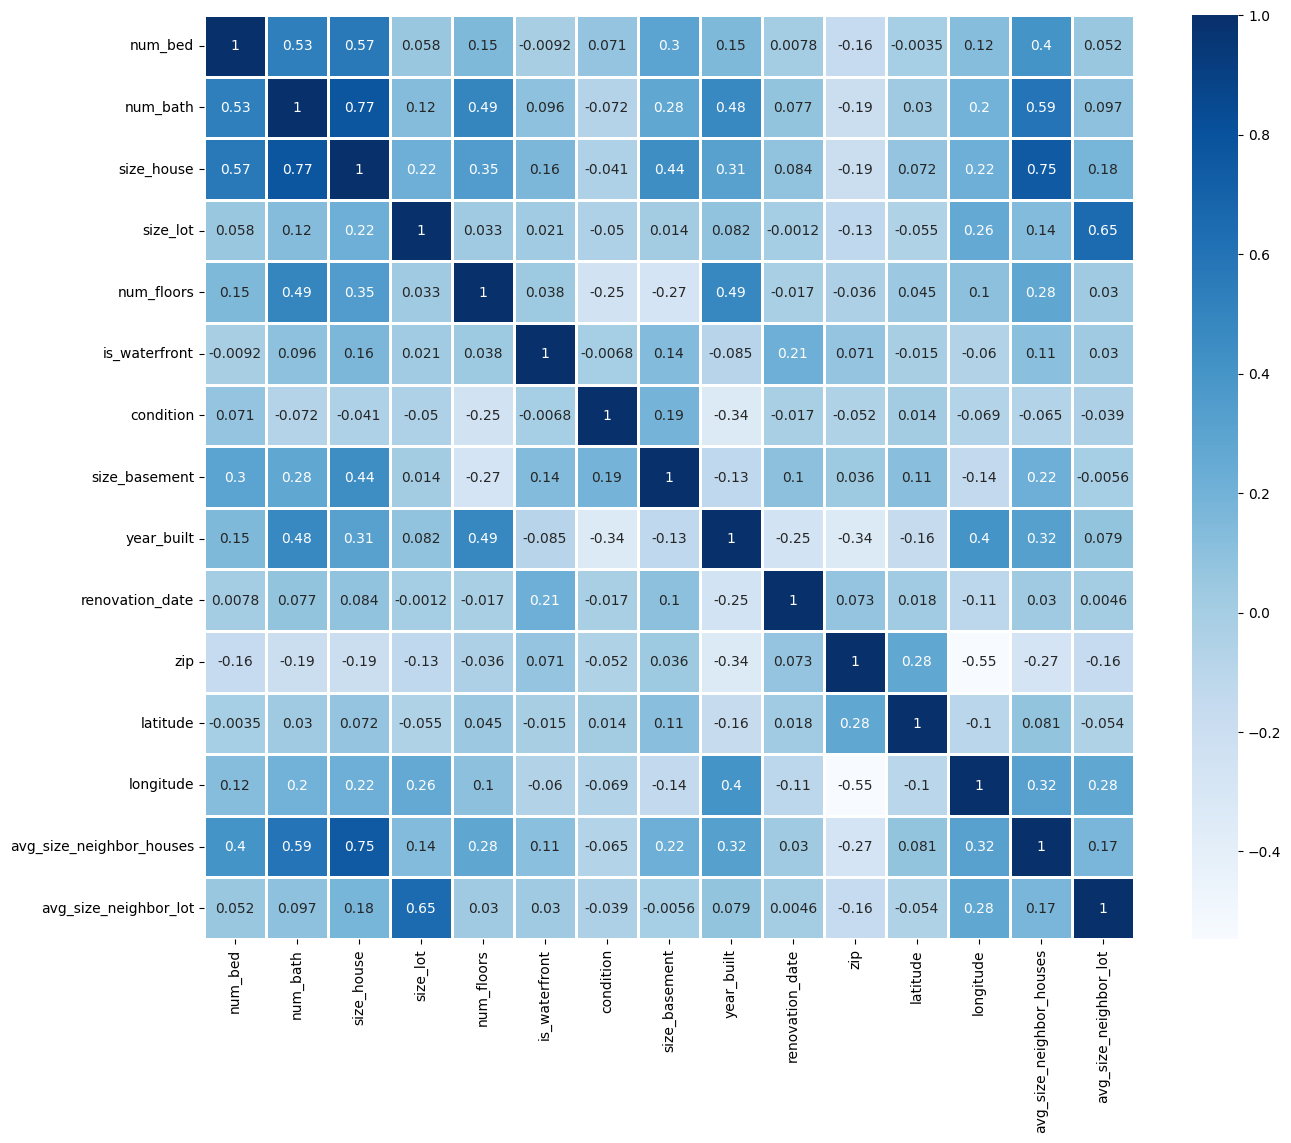

In [12]:
# Estudando a correlçao entre as variaveis independentes por meio do "heatmap"
fig, ax = plt.subplots(figsize=(15,12))
_ = sn.heatmap(df_houses.drop(columns=['price']).corr(), cmap='Blues', linewidth=.8, annot=True);

# <center> Análise Exploratória de Dados (EDA) </center>

Seria interessante:

- Estudasse as distribuições das variáveis (histogramas, boxplots, Quartis, Valor Máximo e Mínimo)

- Estudasse as relações entre as variáveis envolvidas (gráficos de dispersão, histogramas, boxplots, testes de correlação e associação, entre outros)

- Levantasse questionamentos sobre os problemas (levante hipóteses sobre os dados e tente respondê-las usando suas análises)

### Analisar as estatisticas descritivas dos dados

In [13]:
# Análise de inconsistências nos dados
df_houses.describe().T
# Observando a distribuição dos valores nas variaveis

,count,mean,std,min,25%,50%,75%,max
price,1845.0,557127.039024,403208.183409,81000.000000,325000.000000,457000.000000,665000.000000,7.062500e+06
num_bed,1845.0,3.379946,0.939221,0.000000,3.000000,3.000000,4.000000,9.000000e+00
num_bath,1845.0,2.140108,0.785074,0.000000,1.750000,2.250000,2.500000,6.750000e+00
size_house,1845.0,2128.444986,955.754345,410.000000,1440.000000,1950.000000,2620.000000,1.004000e+04
size_lot,1845.0,15642.503523,41323.934402,649.000000,5100.000000,7700.000000,11060.000000,1.024068e+06
num_floors,1845.0,1.518970,0.549520,1.000000,1.000000,1.500000,2.000000,3.500000e+00
is_waterfront,1845.0,0.014092,0.117903,0.000000,0.000000,0.000000,0.000000,1.000000e+00
condition,1845.0,3.382114,0.634172,1.000000,3.000000,3.000000,4.000000,5.000000e+00
size_basement,1845.0,290.643902,461.995804,0.000000,0.000000,0.000000,550.000000,4.820000e+03
year_built,1845.0,1971.820054,29.097993,1900.000000,1952.000000,1976.000000,1997.000000,2.015000e+03


### Dividindo a base de dados em treino e teste

In [14]:
# Segregando os Dados em Treino e Teste
df_train_houses, df_test_houses = train_test_split(df_houses, train_size=0.7, random_state=123)

In [15]:
display(df_train_houses.head())
print(df_train_houses.shape)

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
1307,524000,2,2.00,1450,2272,1.0,0,4,700,1924,0,98112,47.633003,-122.281760,2170,4370
1131,400000,3,1.50,1510,8360,1.0,0,3,390,1960,0,98007,47.611881,-122.132641,1700,8360
1314,205000,4,2.00,2200,13320,1.0,0,3,1100,1944,0,98168,47.480992,-122.292087,1330,6099
748,720000,4,2.50,3450,39683,2.0,0,3,0,2002,0,98010,47.342008,-122.025495,3350,39750
346,664000,2,1.75,1720,5785,1.0,0,3,860,1948,2002,98118,47.555390,-122.274284,1680,5184


(1291, 16)


### Analisando as distribuições dos dados nas variaveis do dataset treino

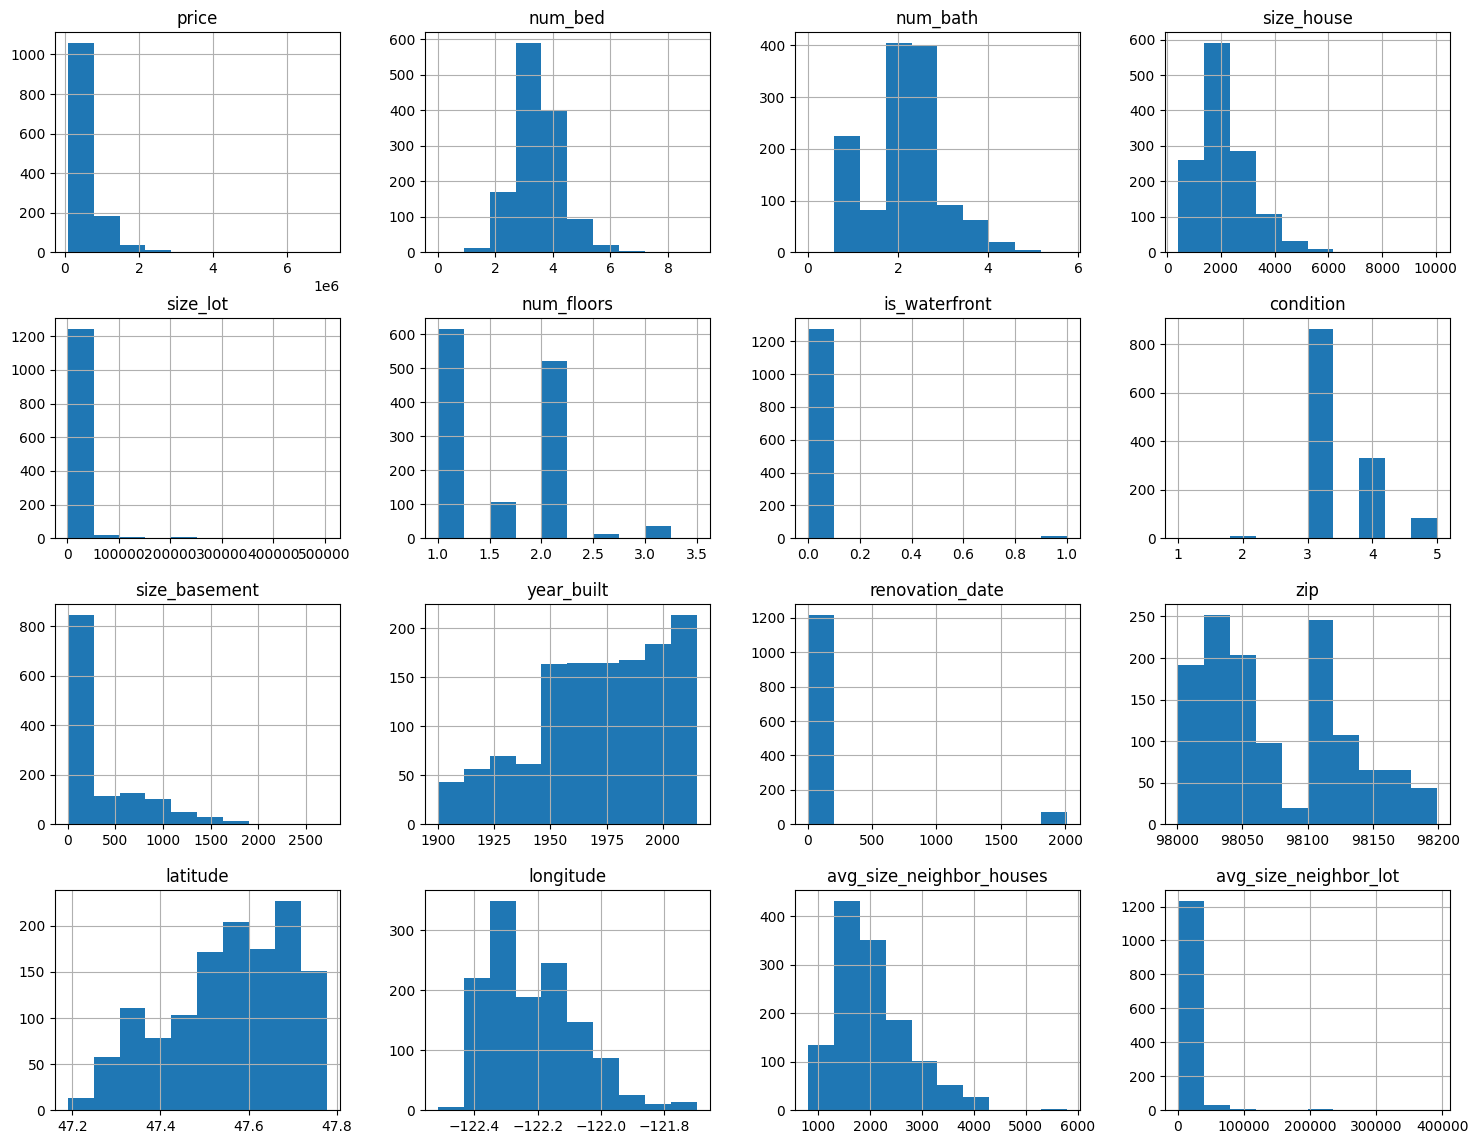

In [16]:
# Estudo das distribuções das variáveis
df_train_houses.hist(figsize=(18,14));
# figsize =  18  comprimento do eixo X e 14  altura do eixo Y

Nossa variável resposta, price, é assimétrica. Poderemos propor uma transformação para ela.

### Transformação logarítmica ``np.log`` Numpy

* É uma técnica que é amplamente utilizada em situações em que a variável tem uma **distribuição assimétrica** e/ou uma **grande variância**. O **logaritmo** é uma **operação matemática** diretamente relacionada com as **equações exponenciais**. Nele buscamos **encontrar o expoente** que faz com que a base seja igual ao que chamamos de **logaritmando**

A função ``logarítmica`` é útil para situações como os juros compostos — já que ela é a função inversa da função exponencial — e a **mede a magnitude de terremotos**, há também sua aplicação na química e na **geografia**

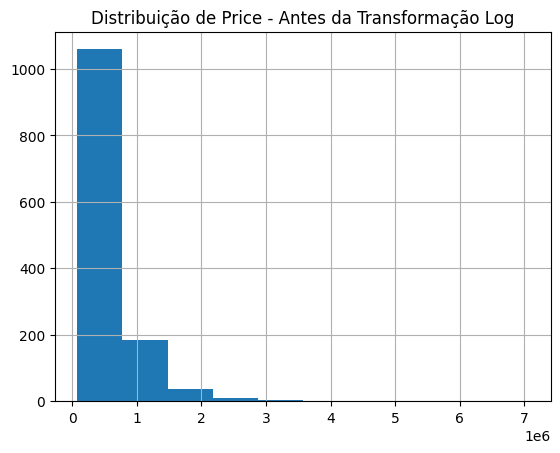

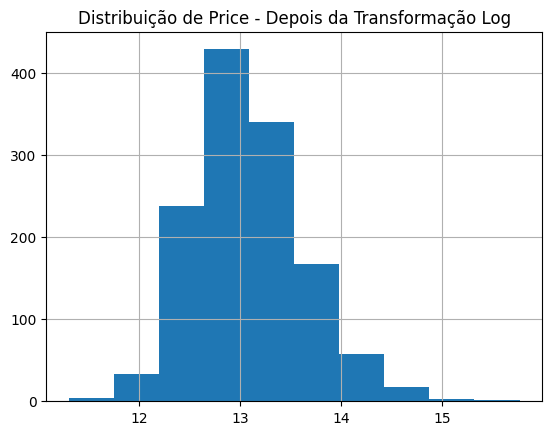

In [17]:
# Visualizando a Distribuição da Variavel price
df_train_houses.price.hist()
plt.title('Distribuição de Price - Antes da Transformação Log')
plt.show()

# Aplicando uma transformação logaritmica (inversa da exponencial)
np.log(df_train_houses.price).hist()
plt.title('Distribuição de Price - Depois da Transformação Log')
plt.show();
# Distribuição mais proximo de uma distribuição normal após transformação Logaritmica

Analisando a **relação** do tamanho do imovel (**"size_house"**) com a sua posição geografica (**"longitude"** e **"latitude"**)

## **H0 (hipotese)**: Existe uma relação entre a **geografia** e o **tamanho das casas** ?

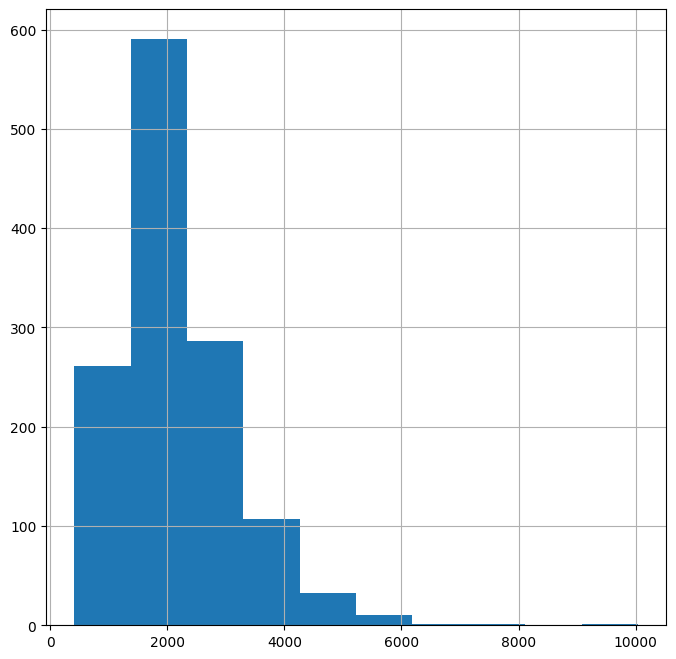

In [18]:
# Analisando a variavel "size_house"
df_train_houses.size_house.hist(figsize=(8,8));
# Observando a ditribuição - Não possui uma distribuição normal

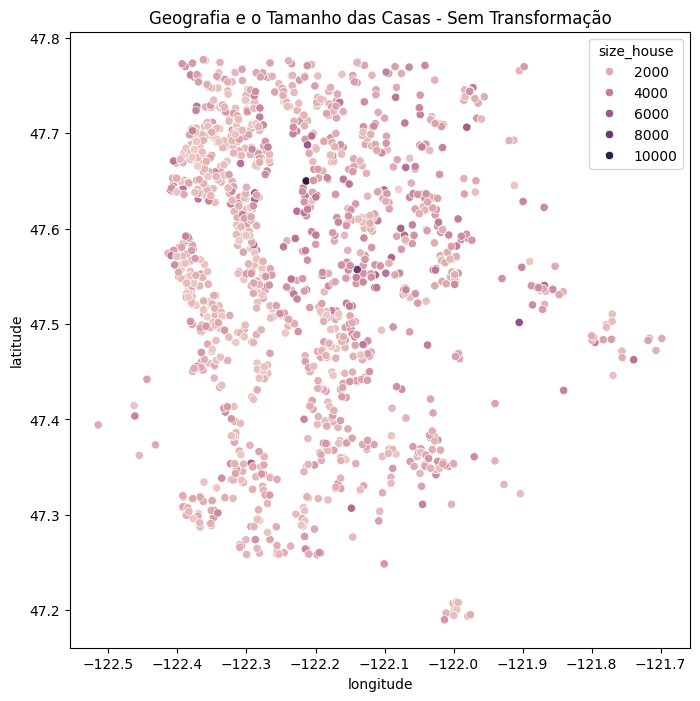

In [19]:
# Plotando um grafico de dispersão com as variaveis 'longitude' e 'latitude' em relaçao a 'size_house'
plt.figure(figsize=(8,8))
sn.scatterplot(data = df_train_houses, x = 'longitude', y = 'latitude', hue = 'size_house')
plt.title('Geografia e o Tamanho das Casas - Sem Transformação')
plt.show()
# Observando a relaçao com a variavel 'size_house' sem normalizar a distribuição

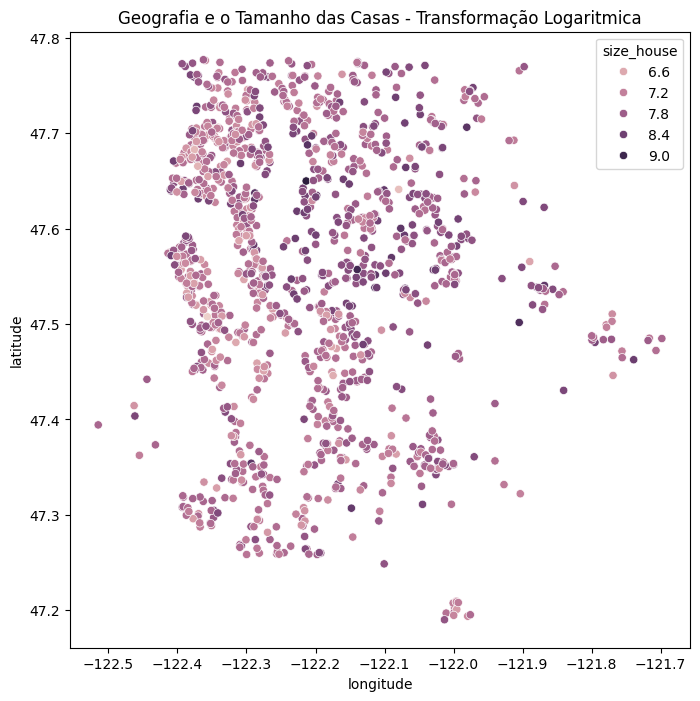

In [20]:
# Plotando um grafico de dispersão com as variaveis 'longitude' e 'latitude' em relaçao a 'size_house' coma distribuição normalizada
plt.figure(figsize=(8,8))
sn.scatterplot(
    x = df_train_houses['longitude'],
    y = df_train_houses['latitude'],
    hue = np.log(df_train_houses['size_house']))
plt.title('Geografia e o Tamanho das Casas - Transformação Logaritmica')
plt.show()
# Observando a relaçao com a variavel 'size_house'  normalizada sua distribuição

**H0**

*Resp*: Aparentemente os **imoveis maiores** parem estar **localizados mais ao centro**

## **H1 (Hipotese um)**: Se os maiores imoveis estão localizados aparentemente mais ao centro os imoveis mais caros também iram estar ?

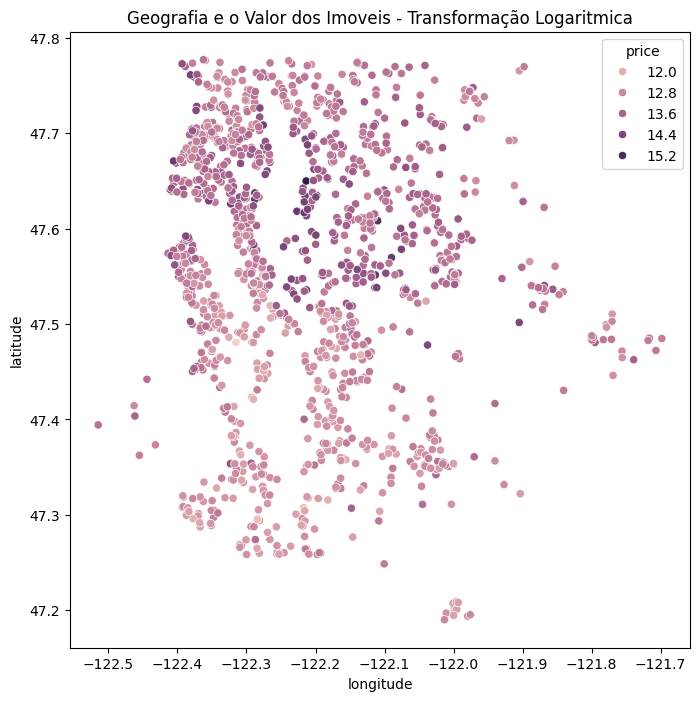

In [21]:
# Plotando um grafico de dispersão com as variaveis 'longitude' e 'latitude' em relaçao a 'price' - distribuição de "price" "normalizada em log"
plt.figure(figsize=(8,8))
sn.scatterplot(
    x = df_train_houses['longitude'],
    y = df_train_houses['latitude'],
    hue = np.log(df_train_houses['price']))
plt.title('Geografia e o Valor dos Imoveis - Transformação Logaritmica')
plt.show()
# Analisar a relação entre a "posição geografica" em comparação com o valor dos imoveis

#### **H1**

*Resp*: Pode se dizer que, **aparentemente sim**, observa se que a localização tanto dos imoveis maiores quanto os mais caros, coincidirem de estarem na mesma região, na mesma **localização geografica**.

## **H2 ( Hipotese Dois)**: Os imoveis mais velhos tendem a ser maiores e mais centralizados ?

#### DataFrame ``pivot_table`` Pandas

A **pivot table** no Pandas, também conhecida como **tabela dinâmica**, é um recurso fundamental em **análise de dados** que permite **resumir, agrupar e reorganizar dados** de maneiras altamente flexíveis.

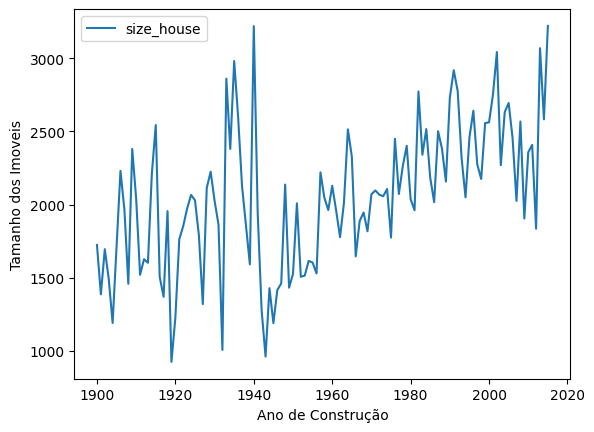

In [22]:
# Extraindo uma Tabela dinamica com a media dos tamanho dos imoveis em relação ao ano de cosntrução
df_train_houses.pivot_table(
    values='size_house',
    columns='year_built',
    aggfunc='mean').T.plot()
plt.xlabel('Ano de Construção')
plt.ylabel('Tamanho dos Imoveis')
plt.show()
# plotando um grafico de linha com o ano de construção com a media de tamanho

#### **H2** - 1º Parte

*Resp*: Na verdade os imoveis tem aumentado de tamanho ao longo dos anos, principalmente, no periodo do pós 2º Guerra Mundial ( Crise de 1929 )

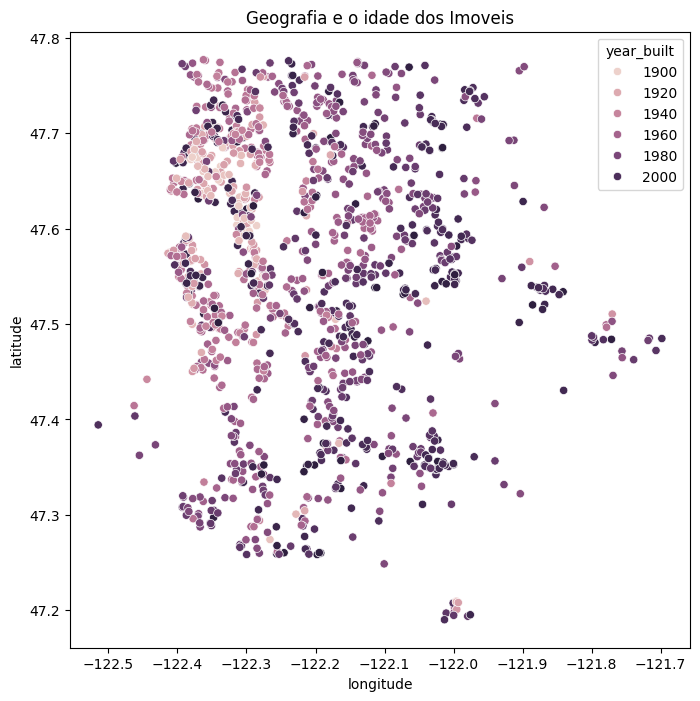

In [23]:
# Observando a localização goegrafica do imovel em referencia a idade do imovel
plt.figure(figsize=(8,8))
sn.scatterplot(
    x = df_train_houses['longitude'],
    y = df_train_houses['latitude'],
    hue = df_train_houses['year_built'])
plt.title('Geografia e o idade dos Imoveis')
plt.show()

#### **H2** -  2º Parte (Final)

*Resp*: Pode se observar no grafico acima que, os imoveis mais antigos, se concentram mais ao canto superior esquerdo, isto pode ser um indicio de ser uma area mais antiga da cidade, a partir da qual a cidade se expandiu. Quanto a premissa a respeito do tamanho dos imoveis, e ano de construção, pode se refutar, pois observa se o cresciment ao longo dos anos.

## **H3 (Hipotese tres)**: Os Imoveis aos quais possuem "is_waterfront" são mais caros e mais afastadas do centro ?

**Grafico** ``Box Plot``


O **Box Plot**, também chamado **diagrama de caixa**, é uma ferramenta gráfica utilizada para ilustrar um conjunto de dados. Por meio dele, é possível **visualizar a distribuição de dados** com base em cinco estatísticas: **o mínimo**, o **primeiro quartil (Q1)**,  a **mediana**, o **terceiro quartil (Q3)**, o **máximo**. Esses valores também são conhecidos como resumo dos cinco números.

Ele também pode **informar os valores discrepantes** (``outliers``) dos dados, oferecendo uma medida complementar para o desenvolvimento de perspectivas sobre as informações passadas através dos dados.  Além disso, o **Box Plot** pode **informar a posição** dos dados, sua **simetria**, **dispersão**, **cumprimento da cauda** de distribuição e se **estão ou não distorcidos**.

No gráfico do **Box Plot**, a **haste vertical** é interpretada de **baixo para cima**, sendo que a **parte inferior indica o mínimo** e a **superior indica o máximo**, sempre **desconsiderando possíveis outliers**.

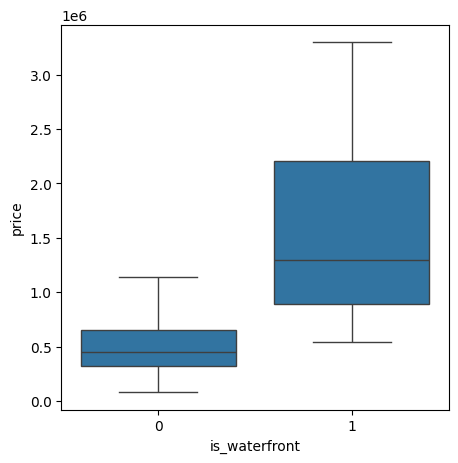

In [24]:
# Dimensionamento do Grafico
plt.figure(figsize=(5,5))
sn.boxplot(
    data = df_train_houses, # Base de Dados
    x = 'is_waterfront', # variavel independente
    y = 'price', # Variavel Dependente
    showfliers=False) # Não Mostrar os dados discrepantes ( outliers )
plt.show()

#### **H3** - 1º Parte

*Resp*: Observa se no grafico acima, conforme a distribuição dos dados se apresentam, que há relação, imoveis com "is_waterfront" são mais caros, e possuem média de valor maior, entretanto, com este grafico não se pode afirmar quanto a localização dos imovei, somente o comprarativo referente ao valor dos imoveis e suas respectivas medias.

#### Analisar a distribuição dos dados em "is_waterfront" e "price"

In [25]:
# Filtrar somente os dados em "price" do dataset, porém, somente os dados que possuem "is_waterfront == 1"
waterf_true_price = df_train_houses.loc[df_train_houses['is_waterfront'] == 1, ['price']]
print(f'Quantidade Total da Amostra: {waterf_true_price.shape[0]} Linhas')
# O total de Imoveis que possuem "is_watwrfront" são 15

Quantidade Total da Amostra: 15 Linhas


In [26]:
# Filtrar somente os dados em "price" do dataset, porém, somente os dados que possuem "is_waterfront == 0"
waterf_false_price = df_train_houses.loc[df_train_houses['is_waterfront'] == 0, ['price']]
print(f'Quantidade Total da Amostra: {waterf_false_price.shape[0]} Linhas')
# O total de Imoveis que possuem "Não is_watwrfront" são 1276

Quantidade Total da Amostra: 1276 Linhas


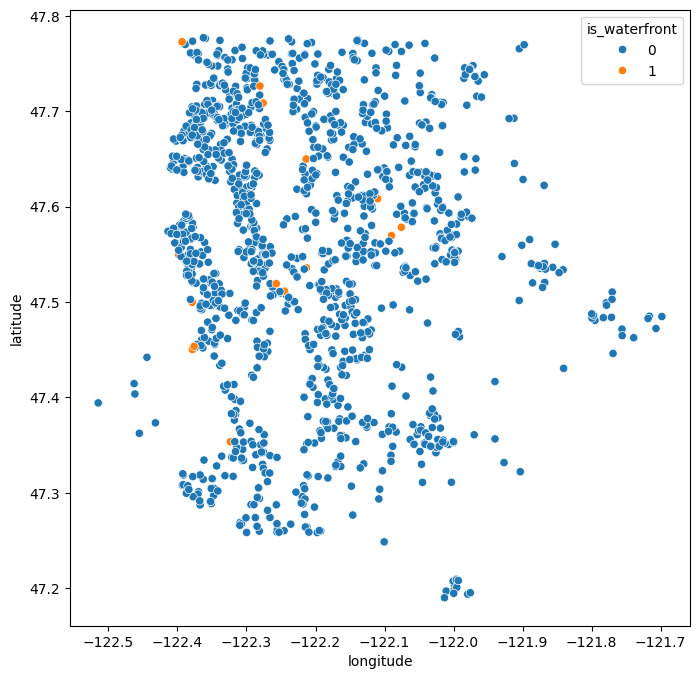

In [27]:
# Plotando um grafico de dispersão entre a localização dos imoveis e se possuem "is_waterfront" ou não
plt.figure(figsize=(8,8))
sn.scatterplot(
    x = df_train_houses['longitude'],
    y = df_train_houses['latitude'],
    hue = (df_train_houses['is_waterfront']))
plt.show()

Esperávamos que as casas waterfront fossem mais afastadas, mas esse padrão não fica evidente. Pesquisando, descobrimos que casas waterfront são aquelas que possuem qualquer coisa de água na frente. ou seja, não precisa ser de frente para praia, rio ou outra coisa necessariamente. É algo que ajuda na ornamentação da casa

#### **H3** - 2º Parte

*Resp:* Pode se observar que exite relação entre o valor dos imoveis, e se, possuem ou não "is_waterfront", porém, pode se observar claramente, tanto na analise quantitativa, quanto na analise grafica, que existe uma desproporcionalidade, um desbalanceamento entre quantidade de 15 amostras com imoveis contendo "is_waterfront", e imoveis que Não possuem "is_waterfront", com um total de 1276 amostras, havendo deste modo, apenas 1.18% das amostras com "is_waterfront" em comparação com 98.82% das amostras que não possuem "is_waterfront", deste modo, não se pode afirmar que, apenas 15 amostras, iram refletir com fidelidade o cenario populacional, e com isso, se faz necessário a verificação das médias, variancia, enfim,  justamente por conta deste desbalanceamento, pois,  se estivéssemos com a mesma quantidade de amostras para ambas as condições, haveria diferebnça entre as médias, a variancia,  ainda continuaria sendo o mesmo valor para ambas as condiçoes, seriam iguais ?

### **H4** (hipotese Nula): Não existe diferença entre as médias

#### ``teste t de Student``

**Teste t de Student**, que é um **teste de hipóteses** utilizado quando queremos tirar **conclusões de um grupo inteiro de indivíduos** com base em apenas uma **pequena amostra coletada**. O ``teste t`` usa conceitos estatísticos para **rejeitar** ou **não uma hipótese nula**. 

O ``Teste T`` é um teste estatístico frequentemente utilizado para** testar hipóteses** sobre **diferenças** entre até **duas médias**. O ``teste t de Student`` é um tipo de **estatística inferencial**, usado para determinar se há uma **diferença significativa** entre as **médias de dois grupos** em alguma **característica determinada**.

#### scipy.stats.``ttest_ind``

* Calcule o teste T para as médias de duas amostras independentes de pontuações. Este é um teste para a hipótese nula de que 2 amostras independentes têm valores médios (esperados) idênticos. Este teste assume que as populações têm variâncias idênticas por padrão. O ``P -valor ou p-value`` avalia quão bem seus dados rejeitam a **hipótese nula** , que afirma que não há relacionamento entre dois grupos comparados. Rejeitar esta hipótese com sucesso indica que seus resultados podem ser estatisticamente significativos.

In [28]:
# Aplicando Teste T para duas amostras
scipy.stats.ttest_ind(
    waterf_true_price, # Distribuição dos Dados para "is_waterfront == 1"
    waterf_false_price,# Distribuição dos Dados para "is_waterfront == 0"
    equal_var = False) # False assume que a variancia populacional "não é igual"

TtestResult(statistic=array([3.18538644]), pvalue=array([0.00660206]), df=array([14.01542684]))

In [29]:
# Aplicando Teste T para duas amostras
Teste_t, p_valor = scipy.stats.ttest_ind(
    waterf_true_price, # Distribuição dos Dados para "is_waterfront == 1"
    waterf_false_price,# Distribuição dos Dados para "is_waterfront == 0"
    equal_var = False) # False assume que a variancia populacional "não é igual"

# Resultado Estatisca t
print(f'Coeficiente da Estatista T: {Teste_t}')

# Resultado valor-p associado à alternativa fornecida.
print(f'Coeficiente de P-Valor: {p_valor}')
# P-valor menor que o nivel de significancia (0,05)

Coeficiente da Estatista T: [3.18538644]
Coeficiente de P-Valor: [0.00660206]


#### **H4**

*Resp*: De acordo com o Teste t, que resultou em um coeficiente de p-valor menor que o nivel de significancia de 0.05, podemos afirmar que sim, exsite diferença entre as médias de preço, a média é maior para casas com "is_waterfront", caso o resultado obtido com o coeficiente de p-valor, maior que o nivel de significancia, rejeitariamos a hipotese nula, e afirmariamos que a média não seria maior, seriam iguais.

### **H5** ( Hipotese Nula): Não existe Correlção Entre Variavel Independente e Target

In [30]:
# Observando a direção e grau de correlações entre as variaveis e "price"
df_train_houses.corr()['price'].sort_values(ascending=False)
# Correlçao de "price com todas as variaveis"

price                       1.000000
size_house                  0.731971
avg_size_neighbor_houses    0.588096
num_bath                    0.516932
size_basement               0.408339
is_waterfront               0.346088
latitude                    0.305275
num_bed                     0.288304
renovation_date             0.214391
num_floors                  0.206018
size_lot                    0.114703
condition                   0.067655
avg_size_neighbor_lot       0.061243
year_built                  0.006759
longitude                   0.002704
zip                        -0.040757
Name: price, dtype: float64

In [31]:
# 1º Opção - Removendo a variavel "is_waterfront" p-valor muito abaixo do nivel de significancia
num_cols0 = df_train_houses.drop('is_waterfront', axis=1).columns.tolist()

In [32]:
# 2º Opção - Removendo a variavel "is_waterfront" p-valor muito abaixo do nivel de significancia
num_cols1 = list(df_train_houses.drop('is_waterfront', axis=1).columns)

## Teste de Correlação de Pearson

Em **estatística descritiva**, o **coeficiente de correlação** de ``Pearson``, também chamado de "**coeficiente de correlação** ``produto-momento``" ou simplesmente de "``ρ de Pearson``", é uma **análise paramétrica** que **mede o grau da correlação** e a **direção** dessa correlação, se positiva ou negativa,  entre duas **variáveis de escala métrica**.

O **Coeficiente de Correlação de Pearson** é uma técnica para **medir se duas variáveis** estão relacionadas de **maneira linear**. Esse é considerado o método mais confiável para medir essa relação, porque se **baseia na covariância**.

**Estatística paramétrica** presume que os **dados são provenientes** de um tipo de **distribuição de probabilidade** e faz inferências sobre os **parâmetros da distribuição**.

**Interpretabilidade**:

* 0.9 para mais ou para menos indica uma correlação muito forte.
* 0.7 a 0.9 positivo ou negativo indica uma correlação forte.
* 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
* 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
* 0 a 0.3 positivo ou negativo indica uma correlação desprezível.


**Calcula-se o coeficiente de ``correlação de Pearson`` segundo a seguinte fórmula:**

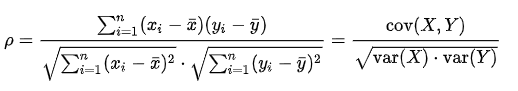


### scipy.stats.``pearsonr``

* Coeficiente de correlação de Pearson e valor p para teste de não correlação. O coeficiente de correlação de Pearson [1] mede a relação linear entre dois conjuntos de dados. Como outros coeficientes de correlação, este varia entre -1 e +1, com 0 implicando nenhuma correlação. Correlações de -1 ou +1 implicam uma relação linear exata. Correlações positivas implicam que à medida que x aumenta, y também aumenta. Correlações negativas implicam que à medida que x aumenta, y diminui.

In [33]:
# Lista das variveis com p-valor menor que o "nivel de significancia 0.05"
correlation_features = []

# Looping para segregar as mais correlacionadas das menos correlacionadas a "price"
for col in num_cols1:
    cor, p = scipy.stats.pearsonr(df_train_houses[col], df_train_houses['price']) # Aplicando Correlçao de Pearson com relaçao a variavel "price"
    if p <= 0.05: # Nivel de Significancia em relaçao ao p-valor
        print(f'p-value: {p},  correlation: {cor}')
        print(f'Existe correlação diferente de zero entre {col} e price.')
        print('--'*30)
        correlation_features.append(col) # Adicionando a lista as variaveis abaixo de 0.05 no p-valor


    else:
        print(f'p-value: {p},  correlation: {cor}')
        print(f'Não existe correlação diferente de zero entre {col} e price.')
        print('--'*30)

# Agora trabalhando com a hiposte de correlçao entre variavel independente e alvo , procuramos rejeitar ou aceitar a hipotese nula
# Para teste de hipotese, se analisa o "coeficiente do p-valor", se é abaixo do nivel de significancia de 0.05, se rejeita a hipotese nula

p-value: 0.0,  correlation: 1.0
Existe correlação diferente de zero entre price e price.
------------------------------------------------------------
p-value: 3.9257897121786383e-26,  correlation: 0.2883038202620258
Existe correlação diferente de zero entre num_bed e price.
------------------------------------------------------------
p-value: 4.057303735652161e-89,  correlation: 0.5169323289507424
Existe correlação diferente de zero entre num_bath e price.
------------------------------------------------------------
p-value: 4.834977119793821e-217,  correlation: 0.7319711564277765
Existe correlação diferente de zero entre size_house e price.
------------------------------------------------------------
p-value: 3.6118967721948415e-05,  correlation: 0.114703433369587
Existe correlação diferente de zero entre size_lot e price.
------------------------------------------------------------
p-value: 7.690747618122645e-14,  correlation: 0.20601847018219985
Existe correlação diferente de zero e

## Teste de Spearman


Em estatística, o **coeficiente de correlação de postos de Spearman**, ou **rô de Spearman**, frequentemente denotado pela letra grega rô, é uma **medida não paramétrica** de **correlação de postos**.

O **coeficiente ``ρ`` de Spearman** mede a **intensidade da relação** entre **variáveis ordinais**. Usa se, em vez do valor observado, apenas a **ordem das observações**. O coeficiente **avalia** com que **intensidade a relação** entre **duas variáveis** pode ser descrita pelo uso de uma **função monótona**.

Enquanto a **correlação de Pearson avalia relações lineares, a **correlação de Spearman avalia relações monótonas**, sejam elas **lineares ou não**. Se **não** houver **valores de dados repetidos**, uma **correlação de Spearman** perfeita de ``+1 ou -1`` ocorre quando cada uma das variáveis é uma **função monótona perfeita da outra**.

**Calcula-se o ``coeficiente de correlação de Spearman`` segundo a seguinte fórmula:**

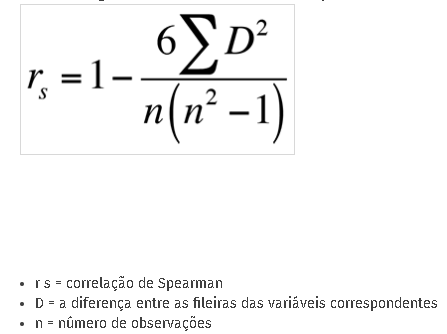


### scipy.stats.``spearmanr``

* Calcule um coeficiente de correlação de Spearman com valor p associado. O coeficiente de correlação de ordem de classificação de Spearman é uma medida não paramétrica da monotonicidade do relacionamento entre dois conjuntos de dados. Como outros coeficientes de correlação, este varia entre -1 e +1, com 0 implicando nenhuma correlação. Correlações de -1 ou +1 implicam uma relação monotônica exata. Correlações positivas implicam que à medida que x aumenta, y também aumenta. Correlações negativas implicam que à medida que x aumenta, y diminui. O valor p indica aproximadamente a probabilidade de um sistema não correlacionado produzir conjuntos de dados que tenham uma correlação de Spearman pelo menos tão extrema quanto aquela calculada a partir desses conjuntos de dados

In [34]:
correlation_features0 = []

for col in num_cols0:
    cor, p = scipy.stats.spearmanr(df_train_houses[col], df_train_houses['price'])
    if p <= 0.05:
        print(f'p-value: {p},  correlation: {cor}')
        print(f'Existe correlação diferente de zero entre {col} e price.')
        print('--'*30)
        correlation_features0.append(col)
    else:
        print(f'p-value: {p},  correlation: {cor}')
        print(f'Não existe correlação diferente de zero entre {col} e price.')
        print('--'*30)

p-value: 0.0,  correlation: 0.9999999999999999
Existe correlação diferente de zero entre price e price.
------------------------------------------------------------
p-value: 6.551052073274742e-36,  correlation: 0.33819943032111327
Existe correlação diferente de zero entre num_bed e price.
------------------------------------------------------------
p-value: 1.872577377385897e-85,  correlation: 0.5075275100118686
Existe correlação diferente de zero entre num_bath e price.
------------------------------------------------------------
p-value: 5.322534183133271e-173,  correlation: 0.6758295223714146
Existe correlação diferente de zero entre size_house e price.
------------------------------------------------------------
p-value: 0.00010789316825990768,  correlation: 0.10755837763532168
Existe correlação diferente de zero entre size_lot e price.
------------------------------------------------------------
p-value: 1.346686896601028e-26,  correlation: 0.2909078539515973
Existe correlação dif

A **Correlação de Pearson**, que é uma **análise paramétrica** para **medir se duas variáveis estão relacionadas de maneira linear**. Outra é a **Correlação de Spearman**, que é uma **medida não paramétrica** da associação entre os **postos das variáveis**.

Os modelos estatísticos **paramétricos** pressupõem que os **dados** são provenientes de um tipo de **distribuição de probabilidade**, e dessa maneira, são feitas **inferências** sobre os **parâmetros da distribuição**. A estatísticas **não-paramétrica não dependem que os dados** sejam provenientes de um tipo de **distribuição de probabilidade**.

 **Estatística Não-Paramétrica**: independe dos parâmetros populacionais e de suas respectivas estimativas. Assim, se a variável populacional analisada não segue uma distribuição normal e/ou as amostras forem pequenas, pode-se aplicar um teste Não- Paramétrico.

 **Estatística paramétricos**: baseiam-se na lei de distribuição da variável em estudo. Embora existam muitos tipos de leis de distribuição, estas são baseadas nas normais, possuindo dois parâmetros: a média e o desvio padrão; o suficiente para saber a probabilidade.

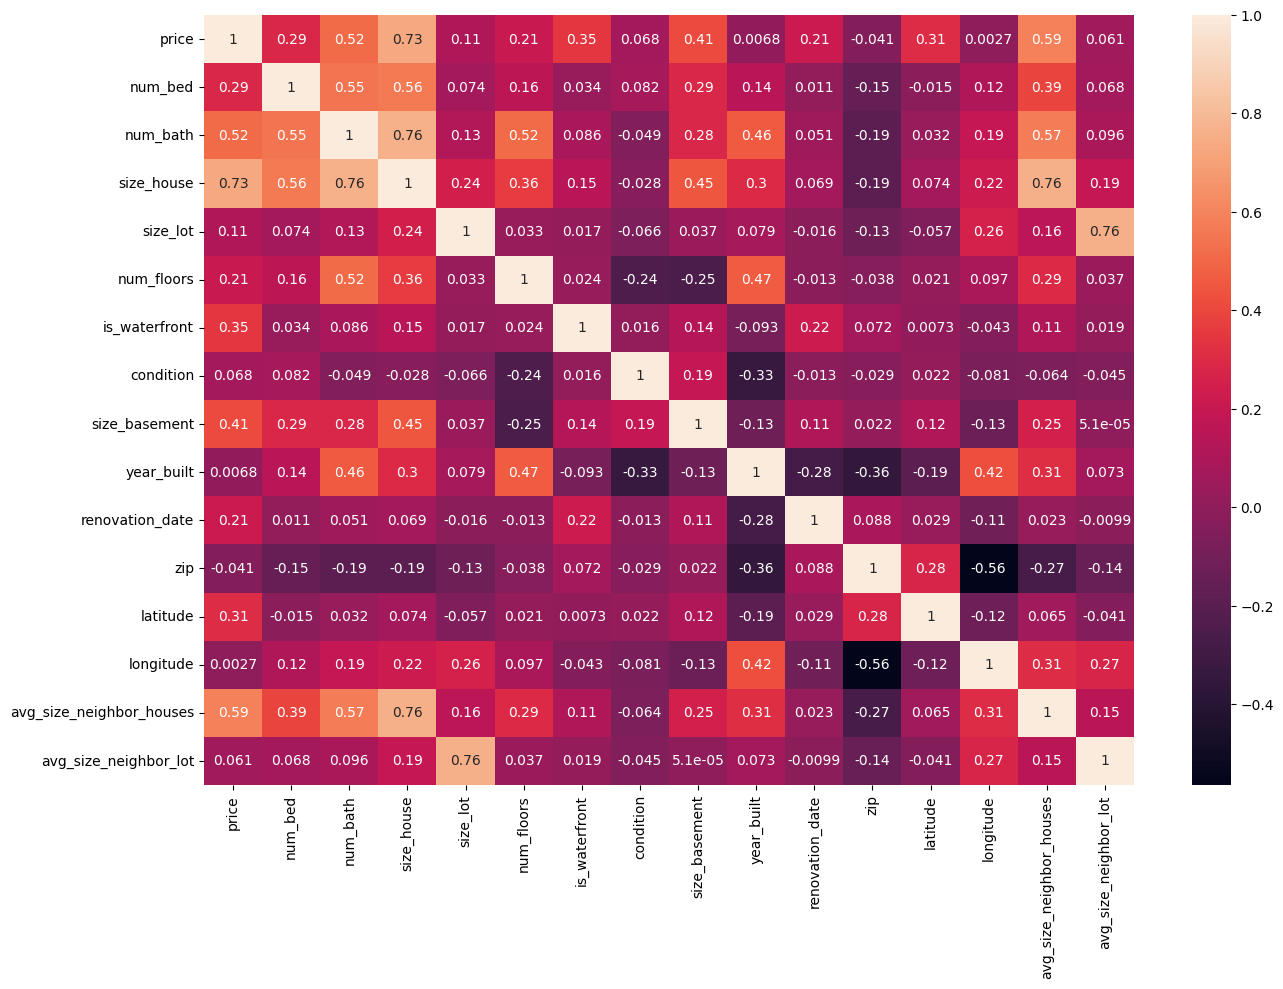

In [35]:
# Gerando mapa de calor (matriz de correlação)
plt.figure(figsize=(15,10))
sn.heatmap(df_train_houses.corr(), annot=True) # Default 'method = pearson' 
plt.show()

In [36]:
# Utilizando as variveis selecionadas
correlation_features

['price',
 'num_bed',
 'num_bath',
 'size_house',
 'size_lot',
 'num_floors',
 'condition',
 'size_basement',
 'renovation_date',
 'latitude',
 'avg_size_neighbor_houses',
 'avg_size_neighbor_lot']

In [37]:
# Gerando um pairplot com as variaveis em "correlation_features"
#sn.pairplot(
#    df_train_houses.loc[:, correlation_features], # Utilizando todos os dados das variaveis correlation_features
#            diag_kind='kde', # "Grafico diagonal" --> "kde" = Estimativa de Densidade de Kernel em camadas (KDE)
#            kind='reg') # "Plotar grafico" --> "reg" = ajusta reta da regressão
#plt.show()

In [38]:
#Quando códigos postais, em geral, é possível agregar reduzindo uma casa numérica.
#df_train_houses['zip_group'] = df_train_houses.zip.astype(str).str[:4]
#zip_group = df_train_houses.groupby('zip_group').aggregate({'price':"mean", 'zip_group':'count'}).sort_values(by='price', ascending=False)
#zip_group

# <center> Modelagem e Avaliação dos Resultados </center>

Nessa fase, espera-se que **crie o modelo** com as **variáveis** que foram **selecionadas** e **avalie o modelo** checando os critérios:

- ``Multicolinearidade``
- ``Homocedasticidade dos resíduos``
- ``Autocorrelação dos Resíduos``
- ``Média 0 nos resíduos``
- ``Estatística F``
- ``P-valores``
- ``MAE, MAPE, MSE, R2``

### 1º -  ``Multicolinearidade``

A **multicolinearidade** é uma situação em que duas ou mais **variáveis independentes** em um **modelo de regressão** encontram-se altamente **correlacionadas**. Essa alta correlação pode **afetar a qualidade dos resultados** do modelo e **dificultar a interpretação** dos resultados.

**Teste de Multicolinearidade - VIF**: Eliminando as features que estão colineares.

In [39]:
# Removendo da listagem a variavel "price"
correlation_features.remove('price')

**VIF** é uma medida estatística que indica o **grau de multicolinearidade** presente em um **modelo de regressão**. Ele é calculado para **cada variável independente** e fornece uma **estimativa da influência da multicolinearidade** na precisão das estimativas dos coeficientes. 

Basicamente, o **VIF** mede quanto a **variância** de um **coeficiente de regressão** é **aumentada devido à multicolinearidade** com as outras **variáveis independentes**. O coeficiente ideal é **abaixo de 10.0**

In [40]:
# Definindo uma função python para teste de multicolinearidade
def multicolinearidade(df, features):
    # Gerando Dataframe com VIF
    vif_data = pd.DataFrame() 
    vif_data["feature"] = df.loc[:,features].columns # Criando uma coluna "features" com todas as informações contidas

    # calculando VIF 
    vif_data["VIF"] = [variance_inflation_factor(df.loc[:,features].values, i) for i in range(len(df.loc[:,features].columns))] 
    # Agregando o resultado do VIF refernte a cada variavel
    return vif_data.sort_values(by='VIF', ascending=False) # Ordenação decrescente a partir de "VIF" 

In [41]:
# Aplicando a função
multicolinearidade(df_train_houses, correlation_features)

,feature,VIF
8,latitude,60.888711
5,condition,33.529701
2,size_house,30.453791
1,num_bath,26.374195
9,avg_size_neighbor_houses,22.689583
0,num_bed,22.385875
4,num_floors,17.121098
10,avg_size_neighbor_lot,2.891168
3,size_lot,2.877475
6,size_basement,2.545819


Como o **coeficiente de VIF ieal é abaixo de 10.0**, vamos **remover as features** com o **maior coeficiente**, começando com o maior valor de multicolinearidade até atingir o resultado ideal.

In [42]:
# 1º - Removendo da lista a feature com "maior coeficiente de VIF" 
correlation_features.remove('latitude')

In [43]:
# Aplicando a função
multicolinearidade(df_train_houses, correlation_features)

,feature,VIF
2,size_house,28.767393
1,num_bath,26.363126
8,avg_size_neighbor_houses,20.519031
0,num_bed,20.164298
4,num_floors,14.160172
5,condition,13.542032
9,avg_size_neighbor_lot,2.891008
3,size_lot,2.860409
6,size_basement,2.536751
7,renovation_date,1.073813


Resover mais outra feature com maior valor de VIF, e observar novamente os coeficientes obtidos

In [44]:
# 2º - Removendo da lista a feature com "maior coeficiente de VIF" 
correlation_features.remove('size_house')

In [45]:
# Aplicando a função
multicolinearidade(df_train_houses, correlation_features)

,feature,VIF
1,num_bath,21.886073
0,num_bed,19.464198
3,num_floors,13.987015
7,avg_size_neighbor_houses,13.884843
4,condition,12.148372
8,avg_size_neighbor_lot,2.890365
2,size_lot,2.781368
5,size_basement,2.100992
6,renovation_date,1.072958


In [46]:
# 3º - Removendo da lista a feature com "maior coeficiente de VIF" 
correlation_features.remove('num_bath')

In [47]:
# Aplicando a função
multicolinearidade(df_train_houses, correlation_features)

,feature,VIF
0,num_bed,16.706231
6,avg_size_neighbor_houses,12.488443
3,condition,11.916182
2,num_floors,9.968077
7,avg_size_neighbor_lot,2.888852
1,size_lot,2.772953
4,size_basement,1.878624
5,renovation_date,1.072021


In [48]:
# 4º - Removendo da lista a feature com "maior coeficiente de VIF" 
correlation_features.remove('num_bed')

In [49]:
# Aplicando a função
multicolinearidade(df_train_houses, correlation_features)

,feature,VIF
5,avg_size_neighbor_houses,11.099645
1,num_floors,9.155303
2,condition,8.705645
6,avg_size_neighbor_lot,2.888262
0,size_lot,2.772567
3,size_basement,1.786470
4,renovation_date,1.071955


In [50]:
# 5º - Removendo da lista a feature com "maior coeficiente de VIF" 
correlation_features.remove('avg_size_neighbor_houses')

In [51]:
# Aplicando a função
multicolinearidade(df_train_houses, correlation_features)

,feature,VIF
2,condition,7.318371
1,num_floors,6.252410
5,avg_size_neighbor_lot,2.876678
0,size_lot,2.760951
3,size_basement,1.557872
4,renovation_date,1.071935


Atingimos um conjunto de variaveis as quais todos possuem coeficiente de VIF abaixo de 10.0, porém, precisamos promover outros testes para confirmar e também observando as metricas obtidas 

## <center> Modelo - 01 </center>

### Sem Multicolinearidade

In [52]:
# Atribuindo a uma variavel todos os dados das "features selecionadas após teste VIF"
X_treino1 = df_train_houses.loc[:,correlation_features]

# Gerando uma "constante" para calculo do "beta-zero"
X_treino1 = sm.add_constant(X_treino1)

# Gerando a "variavel dependente y"
Y_treino1 = df_train_houses['price']

# Gerando os betas
modelo_sem_01 = sm.OLS(Y_treino1, X_treino1) 

# Ajustando a reta
modelo_sem_01 = modelo_sem_01.fit()

### 2º - ``Homocedasticidade ou Heterocedasticidade dos resíduos``

A Homocedasticidade é a variancia constante nos residuos, por outro lado, a heterocedasticidade é um termo estatístico que se refere à presença de variância não constante em uma série de residuos. Em outras palavras, a heterocedasticidade ocorre quando a dispersão dos residuos não é uniformemente distribuidos ao longo da linha de regressão. os erros do modelo (resíduos) devem ser constantes, independente dos valores da variável de resultado (Y). Esse fenômeno é chamado de homocedasticidade ou homogeneidade de variância

In [53]:
# Gerando Predição
y_predict_01 = modelo_sem_01.predict(X_treino1)

In [54]:
# Obtendo os erros
erro_01 = (Y_treino1 - \
          y_predict_01)
# Diferença entre y real e y predição

### ``A média zero dos erros`` 

In [85]:
# Obtendo a média dos erros
print(erro_01.mean())
# A média dos residuos devem ser sempre zero ou, dependendo dos casos, mais proximo de zero possivél

-4.02539114357426e-10


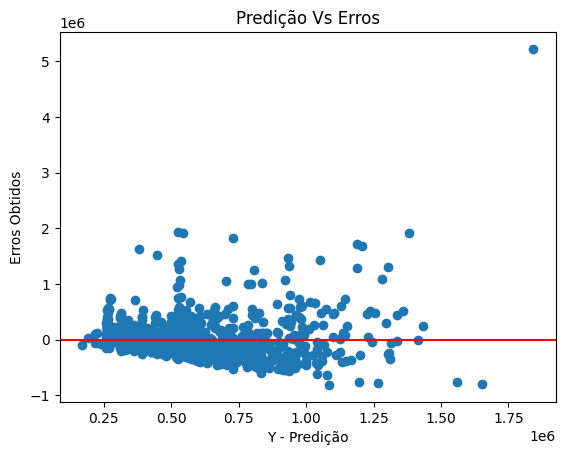

In [55]:
# Gerando um grafico de disperção "y predição" Vs "erros obtidos" com o modelo
plt.scatter(y_predict_01, erro_01)
plt.title('Predição Vs Erros')
plt.xlabel('Y - Predição')
plt.axhline(0, color='r')
plt.ylabel('Erros Obtidos')
plt.show()

Parece haver um pouco de heterocedasticidade, entretanto, pode ser devido ao range da variavel resposta

### ``Autocorrelação dos Resíduos``

Uma autocorrelação positiva, ao ser plotado em um grafico, é identificada por um agrupamento de resíduos com o mesmo sinal, já uma autocorrelação negativa, é identificada por rápidas mudanças nos sinais de resíduos consecutivos. Use a estatística **Durbin-Watson** para testar a presença de autocorrelação.

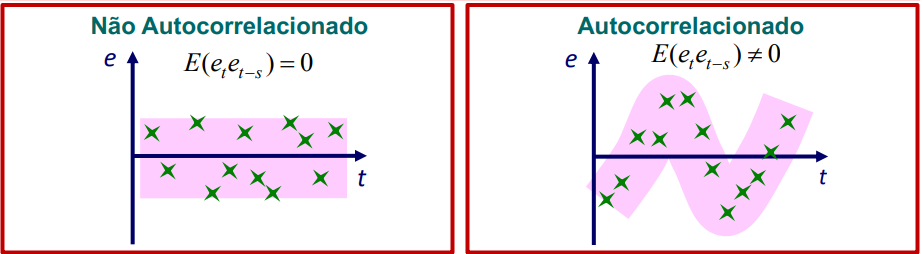

O valor do coeficiente de **Durbin-Watson** sempre está **entre 0 e 4**. Se o coeficiente de Durbin-Watson for **próximo a 2**, significa que **não há autocorrelação** entre os resuduos, e aceitamos a hipótese nula, a qual diz que não há autorelçao entre os residuos, por sua vez, a hipotese alternativa diz que sim, há autocorrelaççao entre os resuduos.

In [57]:
# Gerando um Tabela com o resumo das estatisticas
display(modelo_sem_01.summary())
# Observar coeficiente de Durbin-Watson

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     96.38
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          4.28e-100
Time:                        07:16:23   Log-Likelihood:                -18296.
No. Observations:                1291   AIC:                         3.661e+04
Df Residuals:                    1284   BIC:                         3.664e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -1.47e+05   6.77e+04     -2.172      0.030    -2.8e+05   -1.43e+04
size_lot                  1.4428      0.409      3.524      0.000       0.640       2.246
num_floors             2.604e+05   1.88e+04     13.871      0.000    2.24e+05    2.97e+05
condition              4.829e+04   1.62e+04      2.986      0.003    1.66e+04       8e+04
size_basement           413.1437     22.024     18.759      0.000     369.937     456.350
renovation_date         155.2510     21.073      7.367      0.000     113.910     196.592
avg_size_neighbor_lot    -0.6363      0.546     -1.164      0.244      -1.708       0.436
==============================================================================
Omnibus:                     1227.800   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110999.174
Skew:                           4.122   Prob(JB):                         0.00
Kurtosis:                      47.671   Cond. No.                     3.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Pode observar no resumo das estatisticas, que o coeficiente de Durbin-Watson está muito proximo a 2, praticamente 2, isso mostra que quase não existe autocorrelação entre os residuos.

### ``Estatística F``

Um **teste F** é qualquer **teste estatístico** no qual a estatística de teste **tem uma distribuição F sob a hipótese nula**. É mais frequentemente usado ao **comparar modelos estatísticos** que foram **ajustados a um conjunto de dados**, a fim de identificar o **modelo que melhor se ajusta** à população da qual os dados foram amostrados.

A **estatística F** é simplesmente uma **razão de duas variâncias**. As **variâncias** são uma **medida de dispersão**, ou até que ponto os dados estão **dispersos em relação à sua média**. Valores maiores representam maior dispersão. A **variância é o quadrado do desvio padrão**.

Na tabela de resumos estatisticos acima, a estatistica F aponta que a regressão é valida, porém, o p-valor da variavel "avg_size_neighbor_lot" aponta que devemos remove lá, pois está acima do nivel de significancia de 0.05, então aceitamos a hipotese nula, que não há relação entre a variavel independente(preditora) e a variavel dependente(alvo)

In [58]:
# 6º - Removendo da lista a feature com coeficiente de "p-valor maior que o nivel de singnificancia" 
correlation_features.remove('avg_size_neighbor_lot')

# Atribuindo a uma variavel todos os dados das "features selecionadas após teste VIF"
X_treino3 = df_train_houses.loc[:,correlation_features]

# Gerando uma "constante" para calculo do "beta-zero"
X_treino3 = sm.add_constant(X_treino3)

# Gerando os betas
modelo_price3 = sm.OLS(Y_treino1, X_treino3)

# Treinando o Modelo
modelo_price3 = modelo_price3.fit()

# Extraindo as Previsões
Y_predict_treino3 = modelo_price3.predict(X_treino3)

In [86]:
# Obtendo os erros
erro3 = (Y_treino1-Y_predict_treino3)
# Diferença entre y real e y predição

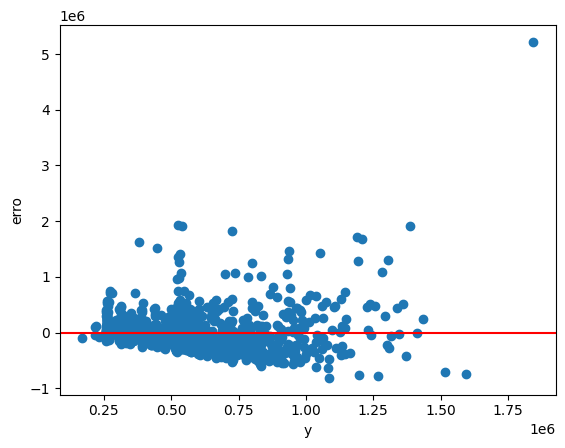

In [87]:
plt.scatter(Y_predict_treino3, erro3)
plt.axhline(0, color='r')
plt.xlabel('y')
plt.ylabel('erro')
plt.show()

In [88]:
# Obtendo a média dos erros
print(erro3.mean())
# A média dos residuos devem ser sempre zero ou, dependendo dos casos, mais proximo de zero possivél

-6.146296154704784e-10


In [61]:
display(modelo_price3.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     115.4
Date:                Fri, 16 Feb 2024   Prob (F-statistic):          7.42e-101
Time:                        07:16:23   Log-Likelihood:                -18297.
No. Observations:                1291   AIC:                         3.661e+04
Df Residuals:                    1285   BIC:                         3.664e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.486e+05   6.77e+04     -2.195      0.028   -2.81e+05   -1.58e+04
size_lot            1.0822      0.268      4.042      0.000       0.557       1.607
num_floors       2.602e+05   1.88e+04     13.856      0.000    2.23e+05    2.97e+05
condition        4.796e+04   1.62e+04      2.966      0.003    1.62e+04    7.97e+04
size_basement     414.2242     22.007     18.822      0.000     371.050     457.399
renovation_date   155.0388     21.075      7.357      0.000     113.694     196.384
==============================================================================
Omnibus:                     1227.302   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           110316.565
Skew:                           4.122   Prob(JB):                         0.00
Kurtosis:                      47.529   Cond. No.                     2.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## <center>``MAE, MAPE , MSE, R2`` - Métricas de Erros </center>

### ``MAPE`` - **Erro Absoluto Percentual Médio**

Esta é uma métrica para avaliar modelos de regressão e é expressa em porcentagem.

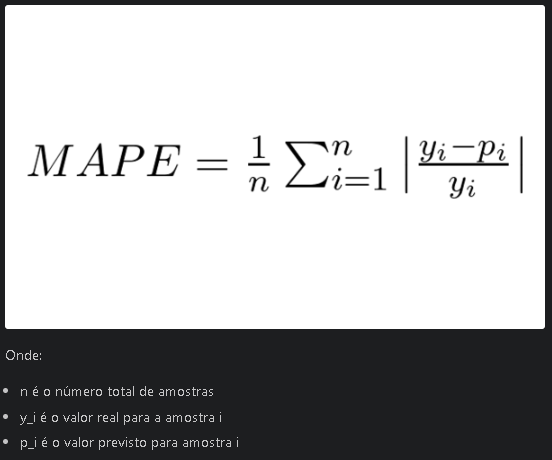

In [62]:
# Gerando uma função python "MAPE"
def mape(Y,y):
    # Aplicando a equação MAPE
    return np.mean(abs(Y - y)/ Y)

In [63]:
# Gerando uma função python "MAPE"
def MAPE(y_real, y_pred):
    # Gerando total de amostras
    n = len(y_real)
    # Aplicando a equação "MAPE"
    return 1 / n * sum(abs(y_real - y_pred) / y_real)

In [64]:
# Aplicando a função para obter o "coeficiente de MAPE"
mape(Y_treino1, Y_predict_treino3)

0.4415133267435051

In [65]:
# Aplicando a função para obter o "coeficiente de MAPE"
MAPE(Y_treino1, Y_predict_treino3)

0.4415133267435051

In [66]:
# Aplicando a função "sklearn.metrics" para obter o "coeficiente de MAPE"
mean_absolute_percentage_error(Y_treino1, Y_predict_treino3)

0.4415133267435051

### ``MSE`` - **Erro Quadrático Médio**

 O **erro quadrático médio**, ``MSE`` (da sigla em inglês **Mean Squared Error**), é comumente usado para **verificar a acurácia** de modelos e dá um **maior peso aos maiores erros**, já que, ao ser calculado, **cada erro é elevado ao quadrado** individualmente e, após isso, a média desses erros quadráticos é calculada.

 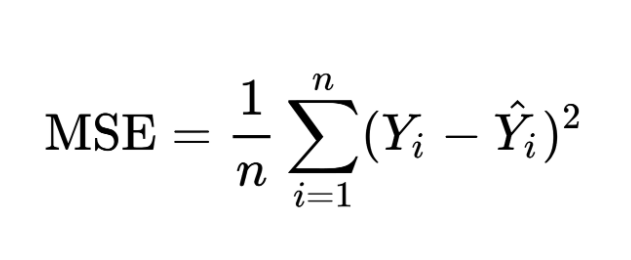


 * **n**: Nº Total de Amostras

 * **Yi**: Valor real da variavel dependente

 * **Y^i**: valor da previsão da variavel dependente

In [67]:
# Gerando uma função python
def MSE(y_real, y_pred):
    # Nº Total de amostras
    n = len(y_real)
    # Aplicando a equação "MSE"
    return 1 / n * sum((y_real - y_pred)**2)

In [68]:
# Obtendo o "Coeficiente de MSE"
MSE(Y_treino1, Y_predict_treino3)

119550541674.35522

In [69]:
# Obtendo o "Coeficiente de MSE" com "sklearn.metrics"
mean_squared_error(Y_treino1, Y_predict_treino3)

119550541674.35526

### ``RMSE`` - **Raiz do erro quadrático médio**: 

É a medida que calcula a **raiz quadrática média** dos **erros** entre **valores observados** (reais) e **predições** (hipóteses).

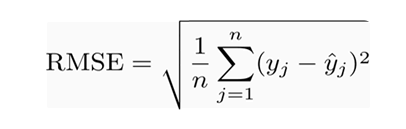


 * **n**: Nº Total de Amostras

 * **Yi**: Valor real da variavel dependente

 * **Y^i**: valor da previsão da variavel dependente

In [70]:
# Gerando uma função python
def RMSE(y_real, y_pred):
    # Nº Total de amostras
    n = len(y_real)
    # Aplicando a equação "RMSE"
    return ((1 / n) * sum((y_real - y_pred)**2))**(1/2)

In [71]:
# Aplicando a Função e Obtendo "Coeficiente de RMSE"
RMSE(Y_treino1, Y_predict_treino3)

345760.8157011943

In [72]:
# Obtendo "Coeficiente de RMSE"
np.sqrt(MSE(Y_treino1, Y_predict_treino3))

345760.8157011943

In [73]:
# # Obtendo "Coeficiente de RMSE" com sklearn.metrics
root_mean_squared_error(Y_treino1, Y_predict_treino3)

345760.8157011943

### ``R²`` - **Coeficiente de Determinação**

O **coeficiente de determinação** é uma medida estatística que é usado para **avaliar a qualidade do ajuste de um modelo de regressão**. Ele é também conhecido como ``R2`` (R ao quadrado) e é uma métrica que **varia de 0 a 1**.

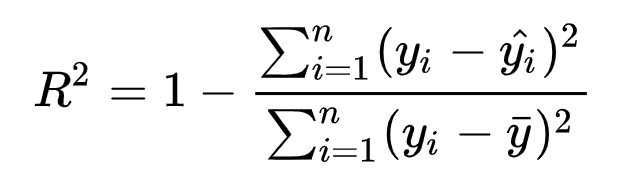

 * **n**: Nº Total de Amostras

 * **Yi**: Valor real da variavel dependente

 * **Y^i**: valor da previsão da variavel dependente

 * **Y~**: A média do valor real

In [74]:
# Gerando uma Função
def R2_score(y_real, y_pred):
    # aplicando a equção do R-Quadrado 
    return (1 - (sum(((y_real - y_pred)**2)) / sum(((y_real - y_real.mean())**2))))

In [75]:
# Obtendo Coeficiente de Determinação
R2_score(Y_treino1, Y_predict_treino3)

0.30979898266480166

In [76]:
# Obtendo "Coeficiente de Determinação com sklearn.metrics"
r2_score(Y_treino1, Y_predict_treino3)

0.30979898266479944

# <center> Teste </center>

#### **Dividindo as Variaveis**

In [89]:
# Gerando variaveis independentes
X_test = df_test_houses.loc[:,correlation_features]

# Gerando variavel dependente
Y_teste = df_test_houses['price']

#### **Calculo Beta-Zero**

In [91]:
# Gerando a constante para beta-zero
X_test = sm.add_constant(X_test)

#### **Utilizando Modelo**

In [92]:
# Gerando previsao
Y_predict_test = modelo_price3.predict(X_test)

#### **Obtendo metricas para os Erros** 

In [93]:
# Extrainido Coeficiente de R2
r2_score(Y_teste, Y_predict_test)
# Quanto maior melhor

0.27914238999169516

In [95]:
# Extrainido Coeficiente de MSE
mean_squared_error(Y_teste, Y_predict_test)
# Quanto menor melhor

98866274971.8746

In [96]:
# RMSE
np.sqrt(mean_squared_error(Y_teste, Y_predict_test))
# Quanto menor melhor

314430.0796232361

In [97]:
# MAPE
mape(Y_teste, Y_predict_test)
# Quanto menor melhor

0.46674780792809617